In [484]:
import os
import sys
from pathlib import Path
import ast
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, hstack
# Setting the working directory to the root of the project
project_dir = Path("C:/Users/adbou/source/repos/KFHXRelatedAi/")
os.chdir(project_dir)

from Configs.GeneralPaths import SOURCEDATA
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [485]:
#load user profiles data
user_profiles = pd.read_excel(Path(SOURCEDATA / "User_Profiles_Reports.xlsx"))
user_profiles.head()
user_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17825 entries, 0 to 17824
Columns: 176 entries, FK_BusinessUserId to RFM_Segment
dtypes: float64(159), int64(15), object(2)
memory usage: 23.9+ MB


In [486]:
user_profiles.head()

,FK_BusinessUserId,total_transactions,total_amount_spent,avg_points_rewarded,avg_amount_spent,total_amount_mcc_763,total_amount_mcc_3038,total_amount_mcc_3583,total_amount_mcc_4111,total_amount_mcc_4225,total_amount_mcc_4468,total_amount_mcc_4814,total_amount_mcc_4900,total_amount_mcc_5047,total_amount_mcc_5085,total_amount_mcc_5099,total_amount_mcc_5111,total_amount_mcc_5131,total_amount_mcc_5199,total_amount_mcc_5261,total_amount_mcc_5262,total_amount_mcc_5300,total_amount_mcc_5309,total_amount_mcc_5310,total_amount_mcc_5399,total_amount_mcc_5499,total_amount_mcc_5533,total_amount_mcc_5651,total_amount_mcc_5712,total_amount_mcc_5732,total_amount_mcc_5733,total_amount_mcc_5812,total_amount_mcc_5815,total_amount_mcc_5816,total_amount_mcc_5817,total_amount_mcc_5818,total_amount_mcc_5940,total_amount_mcc_5942,total_amount_mcc_5944,total_amount_mcc_5947,total_amount_mcc_5949,total_amount_mcc_5960,total_amount_mcc_5962,total_amount_mcc_5965,total_amount_mcc_5967,total_amount_mcc_5968,total_amount_mcc_5969,total_amount_mcc_5970,total_amount_mcc_5972,total_amount_mcc_5977,total_amount_mcc_5992,total_amount_mcc_5993,total_amount_mcc_5995,total_amount_mcc_5999,total_amount_mcc_6300,total_amount_mcc_6540,total_amount_mcc_7211,total_amount_mcc_7216,total_amount_mcc_7221,total_amount_mcc_7230,total_amount_mcc_7251,total_amount_mcc_7273,total_amount_mcc_7277,total_amount_mcc_7297,total_amount_mcc_7299,total_amount_mcc_7321,total_amount_mcc_7338,total_amount_mcc_7361,total_amount_mcc_7375,total_amount_mcc_7392,total_amount_mcc_7393,total_amount_mcc_7399,total_amount_mcc_7512,total_amount_mcc_7523,total_amount_mcc_7993,total_amount_mcc_7996,total_amount_mcc_8111,total_amount_mcc_8299,total_amount_mcc_8351,total_amount_mcc_8398,total_amount_mcc_8911,total_amount_mcc_8999,total_amount_mcc_9399,recency,most_common_day_of_week,most_common_month,most_common_season,most_frequent_mcc,most_frequent_location,763,3038,3583,4111,4225,4468,4814,4900,5047,5085,5099,5111,5131,5199,5261,5262,5300,5309,5310,5399,5499,5533,5651,5712,5732,5733,5812,5815,5816,5817,5818,5940,5942,5944,5947,5949,5960,5962,5965,5967,5968,5969,5970,5972,5977,5992,5993,5995,5999,6300,6540,7211,7216,7221,7230,7251,7273,7277,7297,7299,7321,7338,7361,7375,7392,7393,7399,7512,7523,7993,7996,8111,8299,8351,8398,8911,8999,9399,unique_mccs,weekend_transactions,weekday_transactions,avg_transactions_per_month,R,F,M,RFM_Score,RFM_Segment
0,976481,54,1136.25,210.148148,21.041667,0.0,204.53,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.25,460.49,32.0,147.92,0.00,5.00,0.0,0.00,0.0,0.00,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,68.06,24,0,4,2,5499,KW,0.0,0.055556,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.037037,0.611111,0.018519,0.111111,0.000000,0.018519,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.092593,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.018519,0.0,0.0,0.0,0.000000,0.0,0.0,0.037037,9,15,39,7.714286,5,5,5,5,Champions
1,976482,40,422.74,105.150000,10.568500,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,138.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,73.59,0.0,24.40,14.55,25.50,0.0,105.75,0.0,0.00,0.0,0.0,0.0,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.1,0,0.00,0.0,0.0,0.0,5.95,0.0,0.0,0.0,0.0,0.0,0.0,0.00,76,0,4,1,5812,KW,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.125000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.000000,0.025000,0.050000,0.025000,0.0,0.475000,0.0,0.000000,0.000000,0.000000,0.000000,0.05,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000

In [487]:
user_transactions = pd.read_excel(Path(SOURCEDATA / "Transaction_User.xlsx"))
new_user_transaction = user_transactions.drop(columns=['TrxId'])

deals_data = pd.read_excel(Path(SOURCEDATA / "Rdepemtion_Cleaned_Deals.xlsx"))
deals_data = deals_data.drop(columns=['Unnamed: 0.1'])

deals_profiles = pd.read_excel(Path(SOURCEDATA / "Updated_Content_Profiles.xlsx"))

deals_embeddings = pd.read_csv(Path(SOURCEDATA / "Deals_Embeddings_test.csv"))
deals_embeddings['ada_embedding'] = deals_embeddings['ada_embedding'].apply(ast.literal_eval)

new_user_transaction = new_user_transaction.merge(deals_data[['ContentId', 'Categories','Deal Type']], left_on='FK_ContentId', right_on='ContentId', how='left')
new_user_transaction = new_user_transaction.drop(columns=['ContentId'])

# Load MCC mapping data
mcc_mapping = pd.read_excel(Path(SOURCEDATA / "MCC_Details.xlsx"))
mcc_embeddings = pd.read_csv(Path(SOURCEDATA / "Unique_MCCs_Embeddings.csv"))

# Convert MCC in mcc_mapping to string
mcc_mapping['MCC'] = mcc_mapping['MCC'].astype(str)

In [488]:
deals_profiles

,FK_ContentId,Deal Value Segment,RedemptionCount,TotalPointsRedeemed,MostCommonMonth,MostCommonDayOfWeek,WeekendRedemptionRatio,MostCommonSeason
0,113815,High-End Deal,1,15000,0,0,0.000000,0
1,113816,High-End Deal,1,10000,10,2,0.000000,Autumn
2,113817,High-End Deal,372,1860000,2,2,0.266129,Accross Seasons
3,113818,Medium Budget Deal,1,3000,0,0,0.000000,0
4,113819,Medium Budget Deal,2743,8229000,4,6,0.341232,Spring
...,...,...,...,...,...,...,...,...
195,115227,Medium Budget Deal,150,525000,4,0,0.260000,Spring
196,115229,Medium Budget Deal,1,3500,5,4,0.000000,Spring
197,115231,Medium Budget Deal,25,87500,6,4,0.320000,Spring
198,115244,Low-Budget Deal,100,100000,3,2,0.000000,Accross Seasons


In [489]:
deals_embeddings

,ContentId,ada_embedding
0,113815,"[-0.014375558122992516, 0.014753464609384537, ..."
1,113816,"[-0.033021315932273865, 0.016187822446227074, ..."
2,113817,"[-0.020937858149409294, 0.02548600360751152, -..."
3,113818,"[-0.009052020497620106, 0.011386672966182232, ..."
4,113819,"[-0.014921898022294044, -0.010246079415082932,..."
...,...,...
195,115227,"[-0.035665787756443024, 0.0018958201399073005,..."
196,115229,"[-0.03417283669114113, 0.02079172618687153, -0..."
197,115231,"[-0.007547518704086542, 0.006357964128255844, ..."
198,115244,"[-0.025387734174728394, 0.02967943623661995, -..."


In [490]:
mcc_embeddings

,MCC,ada_embedding
0,5812,"[0.01598844863474369, 0.021374518051743507, -0..."
1,5732,"[-0.044819995760917664, 0.02276458591222763, -..."
2,7230,"[0.009587069042026997, 0.0010589455487206578, ..."
3,4814,"[0.01326761394739151, 0.00438289949670434, -0...."
4,5262,"[-0.05530184507369995, -0.024139152839779854, ..."
...,...,...
73,7393,"[0.013662679120898247, 0.0035436409525573254, ..."
74,5969,"[0.009723884984850883, 0.0003069668891839683, ..."
75,5972,"[0.015417693182826042, 0.021184373646974564, -..."
76,7251,"[-0.03005962073802948, 0.0038998755626380444, ..."


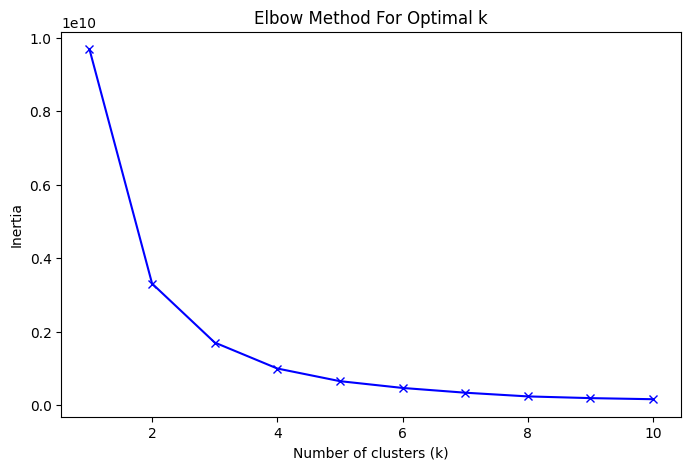

In [491]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Reshape data for clustering
spending_data = user_profiles[['total_amount_spent']].values.reshape(-1, 1)

# Elbow method to determine the optimal number of clusters
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(spending_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


In [492]:
from sklearn.cluster import KMeans

# Reshaping data for clustering
spending_data = user_profiles[['total_amount_spent']].values.reshape(-1, 1)

# Applying KMeans clustering k=3 using elbow method calculated above
kmeans = KMeans(n_clusters=3 , random_state=0).fit(spending_data)
user_profiles['spender_category'] = kmeans.labels_

# Mapping cluster labels to meaningful categories
cluster_map = {0: 'low', 1: 'medium', 2: 'high'}
user_profiles['spender_category'] = user_profiles['spender_category'].map(cluster_map)

print(user_profiles[['FK_BusinessUserId', 'total_amount_spent', 'spender_category']])


       FK_BusinessUserId  total_amount_spent spender_category
0                 976481             1136.25           medium
1                 976482              422.74              low
2                 976483             1905.77           medium
3                 976484              214.26              low
4                 976485             6016.55             high
...                  ...                 ...              ...
17820            1124902                7.95              low
17821            1124919               39.63              low
17822            1124944               22.00              low
17823            1125078                3.75              low
17824            1125100                4.40              low

[17825 rows x 3 columns]


In [680]:
def is_numeric_column(col_name):
    try:
        int(col_name)
        return True
    except ValueError:
        return False


mcc_columns = [col for col in user_profiles.columns if is_numeric_column(col)]

mcc_amounts_cols = [col for col in user_profiles.columns.astype(str) if col.startswith('total_amount_mcc_')]

def calculate_user_interest_score(user_id):
    user_data = user_profiles[user_profiles['FK_BusinessUserId'] == user_id]
    
    total_frequencies = user_data[mcc_columns].sum(axis=1).values[0]
    total_paid_amount = user_data[mcc_amounts_cols].sum(axis=1).values[0]
    
    mcc_scores = {}
    if total_frequencies > 0 and total_paid_amount > 0:
        for mcc in mcc_columns:
            frequency = user_data[mcc].values[0]
            amount_col = f'total_amount_mcc_{mcc}'
            if amount_col in user_data.columns:
                amount = user_data[amount_col].values[0]
                if frequency > 0 and amount > 0:
                    score = 5 * (frequency / total_frequencies) * (amount / total_paid_amount)
                    mcc_scores[mcc] = score
    
    return mcc_scores

In [494]:
def convert_to_array(x):
    if isinstance(x, str):  # If x is a string, try to evaluate it
        try:
            return np.array(ast.literal_eval(x))
        except (ValueError, SyntaxError):
            raise ValueError(f"Cannot convert to array: {x}")
    elif isinstance(x, (list, np.ndarray)):  # If x is already a list or array, convert to np.array
        return np.array(x)
    else:
        raise ValueError(f"Unexpected format: {x}")

In [634]:
def recommend_based_on_profiles(user_id, deal_embeddings, deal_data, user_profiles, mcc_scores_df ,mcc_scores, n_similar_items = 10 , isDf = False , diversity_threshold=0.6):
    # Implementing a recommendation strategy based on user profiles alone
    user_profile = user_profiles[user_profiles['FK_BusinessUserId'] == user_id]
    spender_category = user_profiles.loc[user_profiles['FK_BusinessUserId'] == user_id, 'spender_category'].values[0]
    print(f"Spender Category {spender_category}")

    spender_ranges = {
        'low': ['Low-Budget Deal'],
        'medium': ['Medium Budget Deal'],
        'high': ['High-End Deal']
    }

    recommendations = []

    #user mccs embeddings
    mcc_embeddings['ada_embedding'] = mcc_embeddings['ada_embedding'].apply(convert_to_array)

    # Creating the embeddings dictionary
    mcc_embedding_dict = mcc_embeddings.set_index('MCC')['ada_embedding'].to_dict()

    # Filtering and collecting the embeddings that matches the user's MCC scores
    matched_embeddings = [mcc_embedding_dict[mcc] for mcc in mcc_scores.keys() if mcc in mcc_embedding_dict]


    user_embedding = np.mean(matched_embeddings, axis=0)


    # Getting top MCC scores
    mcc_scores_df = mcc_scores_df.sort_values(by='Score', ascending=False)

    user_mcc_scores = mcc_scores_df.set_index('Detailed MCC')['Score'].to_dict()

    # Filtering deals based on top MCC scores
    top_mcc_deals = deal_data[deal_data['Categories'].isin(user_mcc_scores.keys())]

    for index, row in top_mcc_deals.iterrows():
        content_id = row['ContentId']
        item_mcc = row['Categories']
        deal_segment = deals_profiles.loc[deals_profiles['FK_ContentId'] == content_id, 'Deal Value Segment'].values[0]
        deal_embedding = np.array(deal_embeddings.loc[deal_embeddings['ContentId'] == content_id, 'ada_embedding'].values[0])
        score = cosine_similarity([user_embedding], [deal_embedding])[0][0]
        

        # Adjusting the score based on MCC interest scores of the user
        if item_mcc in user_mcc_scores:
            score *= (1 + user_mcc_scores[item_mcc])
        else:
            score *= 0.8
        
        # Adding weighted adjustment based on spender category
        if spender_category in spender_ranges and deal_segment in spender_ranges[spender_category]:
            score *= 1.5  

        # recency = 1 / (1 + user_profile['recency'].values[0])
        # score *= (1 + 0.3 * recency)

        recommendations.append((content_id, score, item_mcc, deal_embedding))

    # Sorting recommendations by score
    sorted_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    
    #Enforcing Diversity
    final_recommendations = []
    selected_embeddings = []

    for content_id, score, category, embedding in sorted_recommendations:
        if len(final_recommendations) == 0:
            final_recommendations.append((content_id, score, category))
            selected_embeddings.append(embedding)
        else:
            # Calculating similarity with selected embeddings
            similarities = [cosine_similarity(embedding.reshape(1, -1), selected.reshape(1, -1))[0][0] for selected in selected_embeddings]
            max_similarity = max(similarities)
            if max_similarity < diversity_threshold:
                final_recommendations.append((content_id, score, category))
                selected_embeddings.append(embedding)
        
        if len(final_recommendations) >= n_similar_items:
            break
    
    if isDf:
        similar_item_ids = [item for item, score, category in final_recommendations]
        similar_item_scores = [score for item, score, category in final_recommendations]
        categories = [category for item, score, category in final_recommendations]
        recommendations_df = pd.DataFrame({
            'ContentId': similar_item_ids,
            'Score': similar_item_scores,
            'Category': categories
        })
        return recommendations_df
    else:    
        similar_item_ids = [item for item, score, category in final_recommendations]
        similar_item_scores = [score for item, score, category in final_recommendations]

        return similar_item_ids, similar_item_scores


In [679]:
user_id = 985303

mcc_scores = calculate_user_interest_score(user_id)

# Merging the MCC scores with MCC mapping
mcc_scores_df = pd.DataFrame.from_dict(mcc_scores, orient='index', columns=['Score'])
mcc_scores_df.reset_index(inplace=True)
mcc_scores_df.columns = ['MCC', 'Score']
mcc_scores_df['MCC'] = mcc_scores_df['MCC'].astype(str)  # Convert MCC to string
mcc_scores_df = mcc_scores_df.merge(mcc_mapping, on='MCC', how='left')

# Creating labels combining MCC and description
mcc_scores_df['Label'] = mcc_scores_df['MCC'] + ' - ' + mcc_scores_df['Detailed MCC']
mcc_scores_df

recommendations = recommend_based_on_profiles(user_id, deals_embeddings, deals_data, user_profiles, mcc_scores_df , mcc_scores, 20, False)
for content_id, score in zip(*recommendations):
  print(f"Content-Based Recommended deal: {content_id}, Score: {score}, Category: {deals_data.loc[deals_data['ContentId'] == content_id, 'Categories'].values[0]}")

Spender Category low
Content-Based Recommended deal: 115244, Score: 0.8243071979338175, Category: Restaurants and Food Services
Content-Based Recommended deal: 113838, Score: 0.7940726595627919, Category: Personal Services - Health and Beauty Shops
Content-Based Recommended deal: 113883, Score: 0.7802715941692173, Category: Restaurants and Food Services
Content-Based Recommended deal: 113869, Score: 0.7781377617084826, Category: Restaurants and Food Services
Content-Based Recommended deal: 115095, Score: 0.7538772993674796, Category: Restaurants and Food Services
Content-Based Recommended deal: 113896, Score: 0.6682235395996737, Category: Retail Stores
Content-Based Recommended deal: 113825, Score: 0.6632242942271451, Category: Retail Stores
Content-Based Recommended deal: 113986, Score: 0.6616467509060366, Category: Restaurants and Food Services
Content-Based Recommended deal: 113891, Score: 0.6587872943989397, Category: Retail Stores
Content-Based Recommended deal: 113858, Score: 0.6

In [697]:
specific_content_id = 115113,
result = deals_data[deals_data['ContentId'] == specific_content_id]

result

,Unnamed: 0,ContentId,Title,FK_StatusId,Deal Type,Description,Location,Points,Categories
158,158,115113,Get discount from Debenhams,2,Discount,Get 5KD discount from Debenhams,https://www.google.com/maps/search/debenhams+k...,5000,Retail Stores


In [498]:
user_item_matrix = new_user_transaction.pivot_table(index='FK_BusinessUserId', 
                                                    columns='FK_ContentId', 
                                                    values='PointsRedeemed',  # or 'RedemptionCount'
                                                    fill_value=0)

In [499]:
user_item_matrix

FK_ContentId,113816,113817,113819,113823,113824,113829,113830,113833,113834,113835,113837,113842,113843,113844,113851,113853,113863,113864,113872,113875,113876,113882,113883,113885,113911,113915,113916,113923,113964,115007,115013,115074,115075,115094,115095,115096,115099,115104,115105,115107,115111,115112,115115,115120,115122,115132,115133,115134,115135,115136,115154,115163,115177,115191,115207,115209,115211,115213,115215,115217,115218,115221,115223,115225,115227,115229,115231,115244,115259
FK_BusinessUserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
976480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,10.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
976481,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
976482,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
976484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
976485,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1119351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1120134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [500]:
user_item_sparse = csr_matrix(user_item_matrix.values)


In [501]:
print(user_item_matrix.shape)

(25054, 69)


In [502]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

# Initializing the ALS model
model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, use_gpu=False)

# Fitting the model on the user-item sparse matrix
model.fit(user_item_sparse)

# Saving the original columns from the user-item matrix
content_ids = list(user_item_matrix.columns)

# Creating a mapping from user_id and content_id to matrix indices
user_id_to_index = {user_id: index for index, user_id in enumerate(user_item_matrix.index)}
content_id_to_index = {content_id: index for index, content_id in enumerate(content_ids)}





100%|██████████| 20/20 [00:01<00:00, 18.48it/s]


In [674]:
def collaborative_filtering_recommendations(user_id, model, user_id_to_index, content_ids, user_item_matrix, n_recommendations=10):
    user_index = user_id_to_index.get(user_id)
    if user_index is None:
        return []
    
    # Getting the user's interaction vector (a sparse row)
    user_interactions = user_item_matrix[user_index]
    
    # Getting the recommendations (indices and scores)
    recommendations = model.recommend(user_index, user_interactions, N=n_recommendations)
    
    # Mapping back to content IDs using the saved columns and get the scores
    recommended_content_ids_and_scores = [(content_ids[item_id], score) for item_id, score in zip(recommendations[0], recommendations[1])]
    
    return recommended_content_ids_and_scores


recommended_deals_and_scores = collaborative_filtering_recommendations(user_id, model, user_id_to_index, content_ids, user_item_sparse, n_recommendations=20)
for content_id, score in recommended_deals_and_scores:
    print(f"Recommended deal: {content_id}, Score: {score}")

Recommended deal: 113829, Score: 0.4746154844760895
Recommended deal: 115112, Score: 0.4669608473777771
Recommended deal: 113915, Score: 0.40133658051490784
Recommended deal: 113819, Score: 0.34142908453941345
Recommended deal: 113875, Score: 0.28783243894577026
Recommended deal: 115104, Score: 0.2799580693244934
Recommended deal: 113864, Score: 0.2697147727012634
Recommended deal: 113876, Score: 0.2619447112083435
Recommended deal: 115154, Score: 0.2509848177433014
Recommended deal: 115259, Score: 0.25055429339408875
Recommended deal: 115075, Score: 0.1975984275341034
Recommended deal: 115132, Score: 0.19489257037639618
Recommended deal: 113882, Score: 0.16326147317886353
Recommended deal: 113851, Score: 0.148054838180542
Recommended deal: 115207, Score: 0.14755375683307648
Recommended deal: 113834, Score: 0.13661441206932068
Recommended deal: 115134, Score: 0.12562838196754456
Recommended deal: 115215, Score: 0.12358666956424713
Recommended deal: 115105, Score: 0.11287514865398407
Re

In [675]:
def hybrid_recommendation_system(user_id, model, user_id_to_index, content_ids, user_item_matrix, deal_embeddings, deal_data, user_profiles, mcc_scores_df , mcc_scores, n_recommendations=10, max_per_category=2):
    # Generating collaborative filtering recommendations
    cf_recommendations = collaborative_filtering_recommendations(user_id, model, user_id_to_index, content_ids, user_item_sparse, n_recommendations * 2)

    # Generating content-based recommendations (users profiles + deals profiles)
    cb_recommendations, cb_scores = recommend_based_on_profiles(user_id, deal_embeddings, deal_data, user_profiles, mcc_scores_df , mcc_scores, n_recommendations * 2)
    
    # Combining the recommendations
    combined_recommendations = {}
    
    
    for content_id, score in cf_recommendations:
        if content_id not in combined_recommendations:
            combined_recommendations[content_id] = 0.2 * score  # Higher weight for CF
    
    
    for content_id, score in zip(cb_recommendations, cb_scores):
        if content_id in combined_recommendations:
            combined_recommendations[content_id] += 0.8 * score  # adding Lower weight for CB (80 CF / 20 CB)
        else:
            combined_recommendations[content_id] = 0.8 * score
    
    # Sorting by combined scores
    sorted_recommendations = sorted(combined_recommendations.items(), key=lambda x: x[1], reverse=True)
    
    # Enforcing category diversity
    final_recommendations = []
    category_count = {}
    
    for content_id, score in sorted_recommendations:
        deal_category = deal_data.loc[deal_data['ContentId'] == content_id, 'Categories'].values[0]
        
        if category_count.get(deal_category, 0) < max_per_category:
            final_recommendations.append((content_id, score))
            category_count[deal_category] = category_count.get(deal_category, 0) + 1
        
        if len(final_recommendations) >= n_recommendations:
            break
    
    return final_recommendations




In [676]:
# Checking if the user_id is in the user_item_matrix (CB)
user_in_item_matrix = user_id in user_id_to_index

# Checking if the user_id is in the user_profiles (CF)
user_in_profiles = user_id in user_profiles['FK_BusinessUserId'].values

print(f"user id {user_id}")

if user_in_item_matrix and user_in_profiles:
    # Calling hybrid_recommendation_system if user_id is in both
    hybrid_recommended_deals = hybrid_recommendation_system(user_id, model, user_id_to_index, content_ids, user_item_sparse, deals_embeddings, deals_data, user_profiles, mcc_scores_df , mcc_scores, n_recommendations=15)
    for content_id, score in hybrid_recommended_deals:
        print(f"Hybrid Recommended deal: {content_id}, Combined Score: {score}, Category: {deals_data.loc[deals_data['ContentId'] == content_id, 'Categories'].values[0]}")
elif user_in_item_matrix:
    # Only call collaborative_filtering_recommendations if the user is in the user_item_matrix
    recommended_deals_and_scores = collaborative_filtering_recommendations(user_id, model, user_id_to_index, content_ids, user_item_sparse, n_recommendations=15)
    for content_id, score in recommended_deals_and_scores:
        print(f"Collaborative Filtering Recommended deal: {content_id}, Score: {score}, Category: {deals_data.loc[deals_data['ContentId'] == content_id, 'Categories'].values[0]}")
elif user_in_profiles:
    # Only call recommend_based_on_profiles if the user is in the user_profiles
    recommendations = recommend_based_on_profiles(user_id, deals_embeddings, deals_data, user_profiles, mcc_scores_df , mcc_scores, n_similar_items=20)
    for content_id, score in zip(*recommendations):
        print(f"Content-Based Recommended deal: {content_id}, Score: {score}, Category: {deals_data.loc[deals_data['ContentId'] == content_id, 'Categories'].values[0]}")
else:
    # Throwing an error if the user_id is found in neither (future add cold start problem fixing)
    print(f"Error: User {user_id} not found in either user_item_matrix or user_profiles.")


user id 977934
Spender Category high
Hybrid Recommended deal: 115130, Combined Score: 0.6912413391094949, Category: Retail Stores
Hybrid Recommended deal: 113986, Combined Score: 0.6647009732125269, Category: Restaurants and Food Services
Hybrid Recommended deal: 113846, Combined Score: 0.5817295413596121, Category: Personal Services - Health and Beauty Shops
Hybrid Recommended deal: 113973, Combined Score: 0.5594236812213043, Category: Food and Beverage Stores
Hybrid Recommended deal: 115127, Combined Score: 0.5536154918452508, Category: Personal Services - Health and Beauty Shops
Hybrid Recommended deal: 115098, Combined Score: 0.5464015636620501, Category: Retail Stores - Miscellaneous and Specialty
Hybrid Recommended deal: 113919, Combined Score: 0.5425422046309505, Category: Home and Property Services
Hybrid Recommended deal: 113968, Combined Score: 0.5422549025595556, Category: Restaurants and Food Services
Hybrid Recommended deal: 113873, Combined Score: 0.5394114190049363, Cate

In [677]:
specific_content_id = 113975,
result = deals_data[deals_data['ContentId'] == specific_content_id]

result

,Unnamed: 0,ContentId,Title,FK_StatusId,Deal Type,Description,Location,Points,Categories
118,118,113975,Off from Camouflage store,2,Voucher,Get a 15 KD promo code for your next Camouflag...,https://maps.app.goo.gl/wgzU9e3Eaf6umzaT8?g_st...,15000,Retail Stores


In [453]:
user_last_interactions = user_item_matrix.loc[user_id]
user_interacted_items = user_last_interactions[user_last_interactions > 0].index
user_deals = deals_data[deals_data['ContentId'].isin(user_interacted_items)]
user_deals

,Unnamed: 0,ContentId,Title,FK_StatusId,Deal Type,Description,Location,Points,Categories
144,144,115099,Get wallet recharge at Oula Fuel App.,1,Wallet Recharge,Get 5KD wallet recharge at Oula Fuel App.,https://www.google.com/maps/search/%D9%85%D8%A...,5000,Automotive Services


In [520]:
user_trs = new_user_transaction[new_user_transaction["FK_BusinessUserId"] == user_id]
user_trs

,FK_BusinessUserId,PointsRedeemed,FK_ContentId,Categories,Deal Type
5,976518,5000,113834,Food and Beverage Stores,Discount
19,976518,3000,113915,Restaurants and Food Services,Wallet Recharge
